In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt

# London Park Access

In [2]:
# load the graph
G = ox.graph_from_place('London, UK', network_type='walk')

In [3]:
# get nodes and edges
N, E = ox.graph_to_gdfs(G)

# project the nodes and edges to web british national grid
N = N.to_crs(27700)
E = E.to_crs(27700)

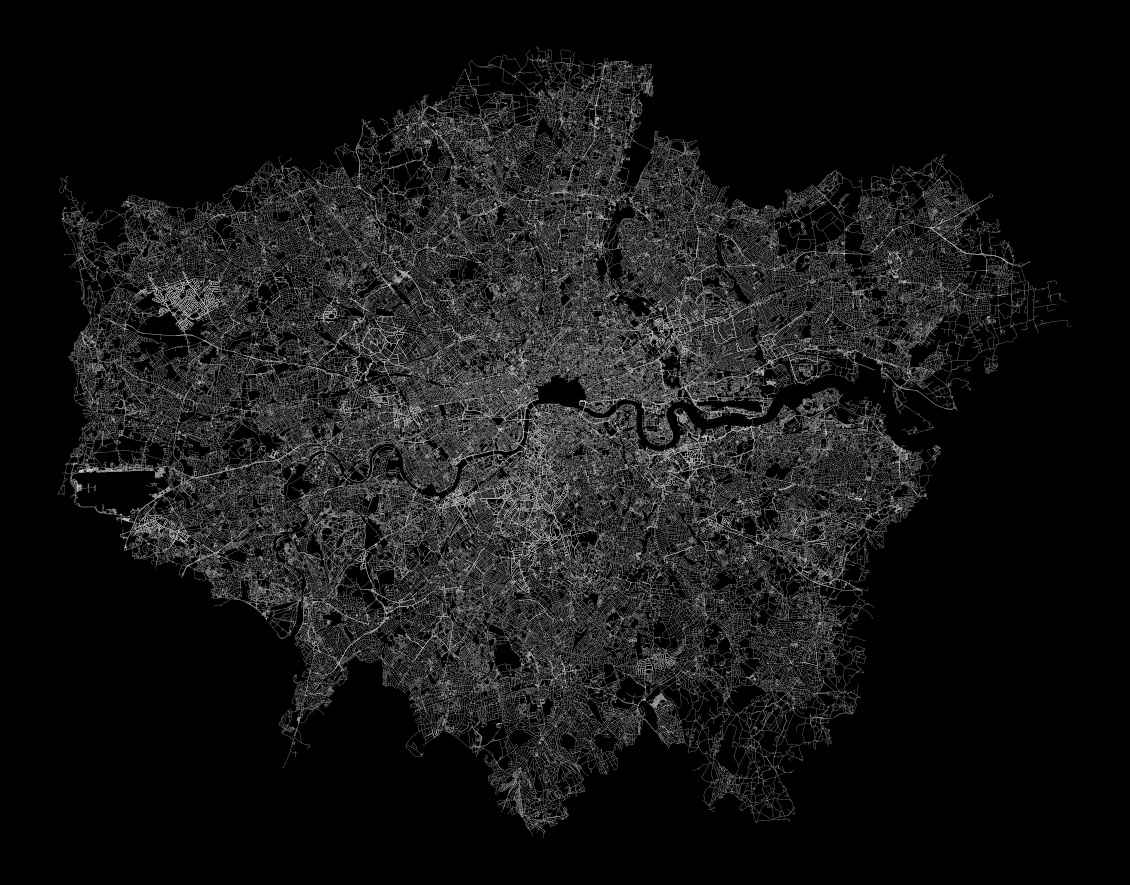

In [4]:
# plot it
fig, ax = plt.subplots(1, 1, figsize = (20, 20), facecolor = 'k')

E.plot(color='w', ax=ax, linewidth=0.1)
ax.set_axis_off()
ax.set_facecolor('k')

In [5]:
# get all parks in london
parks = ox.geometries_from_place('London, UK', tags={'leisure':'park'})

In [6]:
# keep only polygons
parks = parks[parks.geometry.type!="Point"]
parks = parks.dissolve()
parks = parks.explode()

/var/folders/xj/s_z3mksd2s9_pz9rv68sbjxc0000gn/T/ipykernel_66913/1388656462.py:4: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  parks = parks.explode()


In [7]:
# project the park geometries to match the graph
parks = parks.to_crs(27700)

In [8]:
# let's only use parks that are larger than 250m x 250m
parks = parks[parks.geometry.area>250**2]

Parks have pretty convoluted geometries so we can make this easy by just taking the outer segments

In [9]:
from shapely.geometry import Polygon

exteriors = list()

# each geometry has envelope, exterior, bounds, etc
for i in parks.geometry.exterior:
    exterior = Polygon(i)
    exteriors.append(exterior)

In [10]:
# replace the original parks geometry with the exteriors
parks['geometry'] = exteriors

In [11]:
# get all the points where the edges cross the park boundaries
rings = gpd.GeoDataFrame(geometry=parks.geometry.difference(parks.geometry.buffer(-50)), crs='EPSG:27700')

In [12]:
# drop the first index but not the second
rings = rings.dissolve(by=rings.index.get_level_values(1))
rings = rings.reset_index().rename(columns={'index': 'id'})
rings.head()

id                                           geometry
0   5  POLYGON ((512352.580 171220.802, 512342.044 17...
1   9  POLYGON ((510355.251 172067.922, 510449.444 17...
2  11  POLYGON ((508462.482 172007.306, 508474.709 17...
3  12  POLYGON ((507872.309 172027.716, 507869.674 17...
4  15  POLYGON ((509474.960 172237.878, 509489.727 17...

In [13]:
# get only nodes that intersect the rings and drop the right index
entrances = gpd.sjoin(N, rings, how='inner', predicate='intersects').drop(columns='index_right', axis=1)
entrances = entrances[['x', 'y', 'id']].reset_index()
entrances['osmid'] = entrances.osmid.astype('int64')
entrances.head()

osmid         x          y    id
0   99884 -0.152816  51.524364  1337
1   99909 -0.157603  51.524773  1337
2   99910 -0.157981  51.525000  1337
3   99934 -0.161372  51.527615  1337
4  101817 -0.148456  51.535225  1337

In [14]:
# parks.explore()

In [60]:
# remove nodes that are at least 10m inside the park boundary
paths = gpd.sjoin(N,  gpd.GeoDataFrame(geometry=parks.geometry.buffer(-50), crs='EPSG:27700'), how='inner', predicate='intersects')
# get the nodes that are not inside the parks
N_sub = N[~N.index.isin(paths.index)]
# we are essentially cutting on the nodes inside parks so our dijkstra voronois only consider paths that are outside parks
G_sub = G.subgraph(N_sub.index)

In [61]:
# get nodes and edges
N_sub, E_sub = ox.graph_to_gdfs(G_sub)

In [62]:
# remove the geometries from the edges
E_sub = E_sub.reset_index()
E_sub = E_sub.drop('geometry', axis=1)

# remove the geometries from the nodes
N_sub = N_sub.reset_index()
N_sub = N_sub.drop('geometry', axis=1)

In [63]:
# multisource dijkstra requires a set of nodes
node_set = set(entrances.osmid.unique())

Now to measure accessibility we want to associate each node with its nearest park entrance.

In [64]:
# get the shortest paths from all the nodes to all the entraces nodes
%time lines = nx.multi_source_dijkstra_path(G_sub, node_set, weight='length')
# voronoi cells creates a voronoi using the network rather than euclidean distance
%time cells = nx.voronoi_cells(G_sub, node_set, weight='length')

CPU times: user 7.09 s, sys: 155 ms, total: 7.24 s
Wall time: 7.25 s
CPU times: user 8.98 s, sys: 196 ms, total: 9.17 s
Wall time: 9.17 s


In [65]:
# convert the voronoi cells to a dataframe
cells = [pd.DataFrame({'parent': x[0], 'child': list(x[1])}) for x in cells.items()]
cells = pd.concat(cells).merge(entrances, left_on='parent', right_on='osmid', how='left').drop(['x', 'y'], axis=1)

In [66]:
# merge the voronoi cells with the nodes, this will give us the coordinates
cells = cells.merge(N_sub, left_on='child', right_on='osmid', how='left')

In [74]:
from colorcet import palette
from matplotlib import colors

# in this case we need a categorical color map
pal = palette['glasbey_category10']
col = colors.ListedColormap(pal)

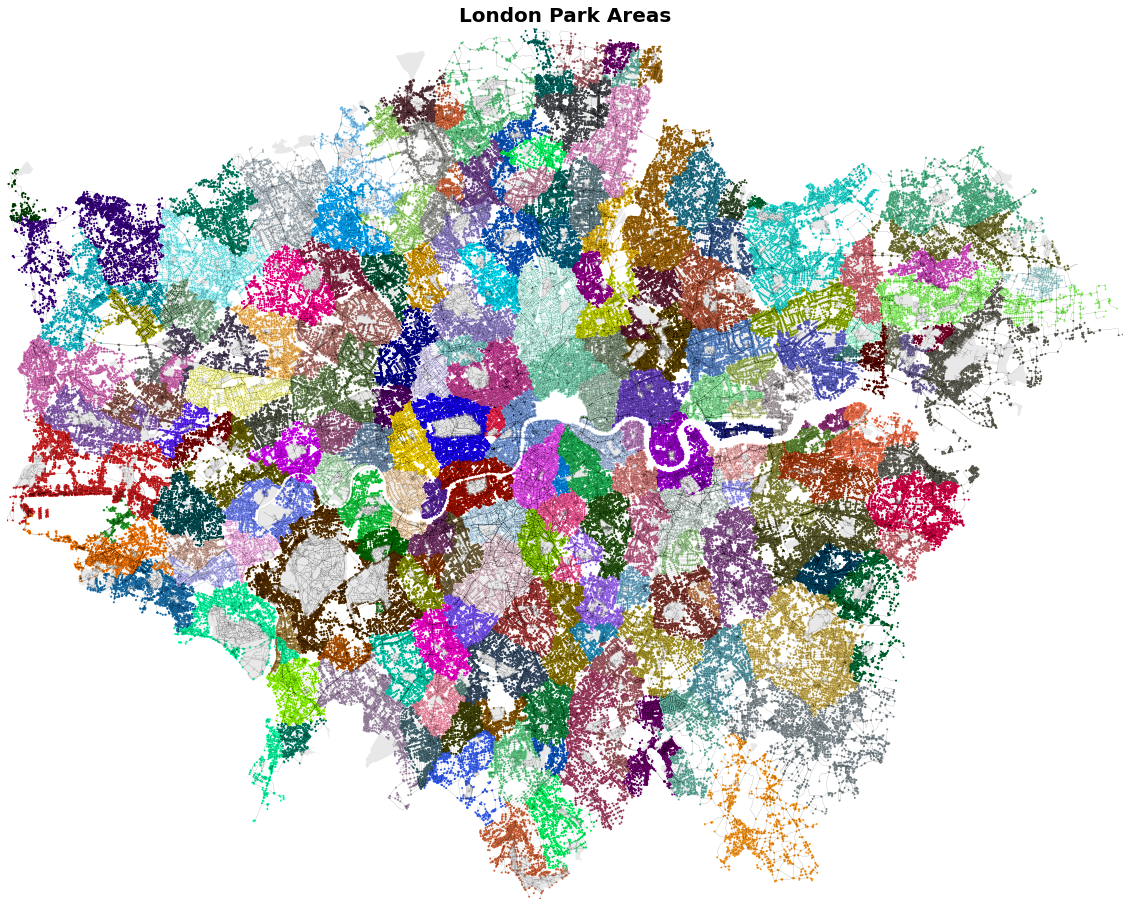

In [75]:
# plot the edges in black
ax = E.plot(color='k', linewidth=0.05, figsize=(20, 20))

# convert the merge cell dataframe to a geodataframe and plot it
gpd.GeoDataFrame(cells, 
                 geometry=gpd.points_from_xy(cells.x, cells.y), 
                 crs=4326).to_crs(27700).plot('id', markersize=1, cmap=col, ax=ax)

# plot the parks in light grey to highlight them
parks.plot(color='lightgrey', alpha=0.5, ax=ax)

# clean up the axes
ax.set_xlim((N.geometry.x.min(), N.geometry.x.max()))
ax.set_ylim((N.geometry.y.min(), N.geometry.y.max()))
ax.set_axis_off()

# add a title
ax.set_title('London Park Areas', fontsize=20, fontweight='bold', color='k')

# save the figure
plt.savefig('./images/accessibility/london_voronoi.png', dpi=300, facecolor='w', bbox_inches='tight')

In [76]:
# let's check the distances to parks from all nodes
%time lengths = nx.multi_source_dijkstra_path_length(G_sub, node_set, weight="length")

CPU times: user 6.88 s, sys: 200 ms, total: 7.08 s
Wall time: 7.08 s


In [77]:
# make a data frame of the lengths
lengths = pd.DataFrame({'osmid':lengths.keys(), 'distance': lengths.values()})

In [78]:
# get a different color map
col = colors.LinearSegmentedColormap.from_list("bmw", palette['bmw'][::-1])

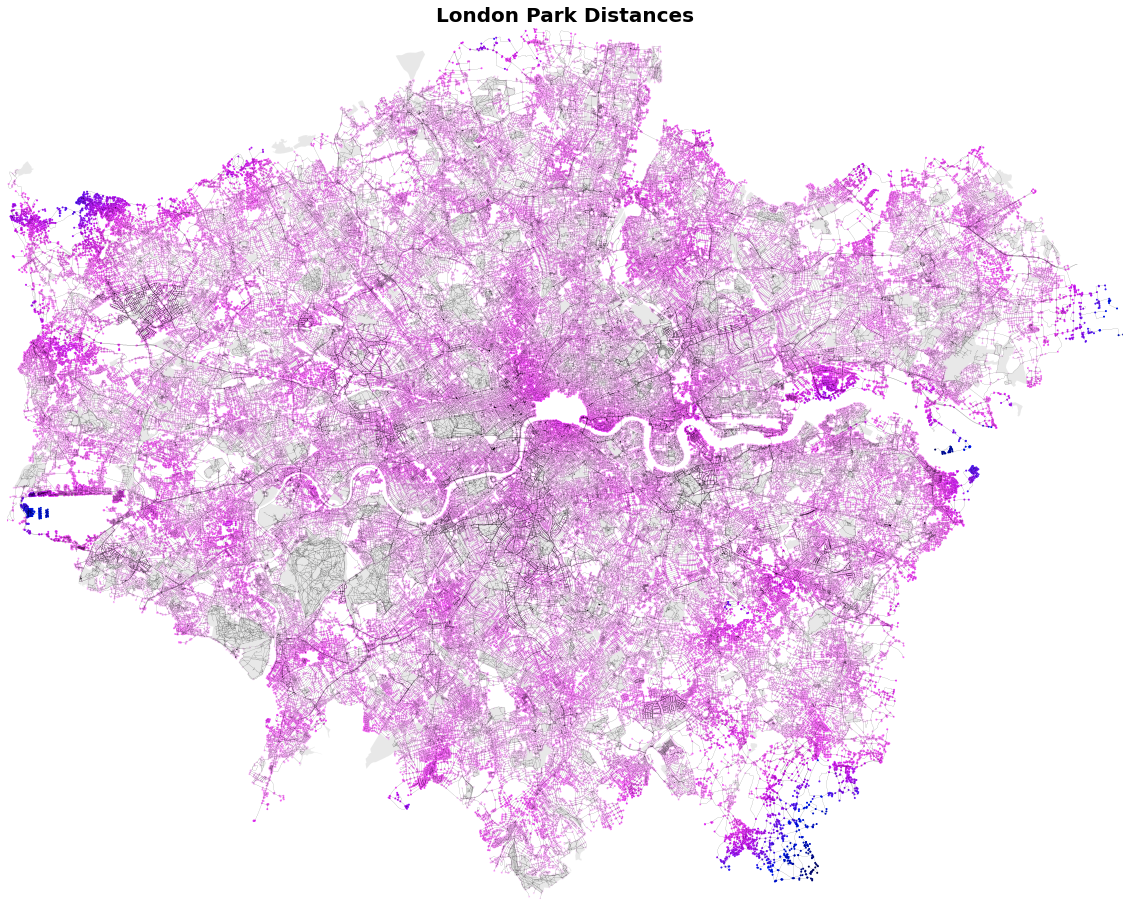

In [79]:
# same as before but with distance as the column of interest
ax = E.plot(color='black', linewidth=0.05, figsize=(20, 20))
gpd.GeoDataFrame(cells, 
                 geometry=gpd.points_from_xy(cells.x, cells.y), 
                 crs=4326).merge(lengths, 
                                 left_on='child', 
                                 right_on='osmid',
                                 how='left').to_crs(27700).plot('distance', markersize=1, cmap=col, ax=ax)

parks.plot(color='lightgrey', alpha=0.5, ax=ax)

# clean up the axes
ax.set_xlim((N.geometry.x.min(), N.geometry.x.max()))
ax.set_ylim((N.geometry.y.min(), N.geometry.y.max()))
ax.set_axis_off()

# add a title
ax.set_title('London Park Distances', fontsize=20, fontweight='bold', color='k')

# save the figure
plt.savefig('./images/accessibility/london_distance.png', dpi=300, facecolor='w', bbox_inches='tight')

Now let's think about walk sheds. Our data is in m and we need to conver that to 20 minutes, a reasonably maximum distance to go to the park. Let's go with 1.5 m/s * 60 seconds * 20 minutes. 

In [80]:
threshold = 1.5 * 60 * 20

In [81]:
# now we enforce a cutoff
%time timed = nx.multi_source_dijkstra_path_length(G_sub, node_set, cutoff=threshold, weight="length")

CPU times: user 5.99 s, sys: 22.3 ms, total: 6.02 s
Wall time: 6.02 s


In [82]:
times = pd.DataFrame({'osmid': timed.keys(), 'distance': timed.values()})

In [83]:
col = colors.LinearSegmentedColormap.from_list("bmw", palette['kbc'][::-1])

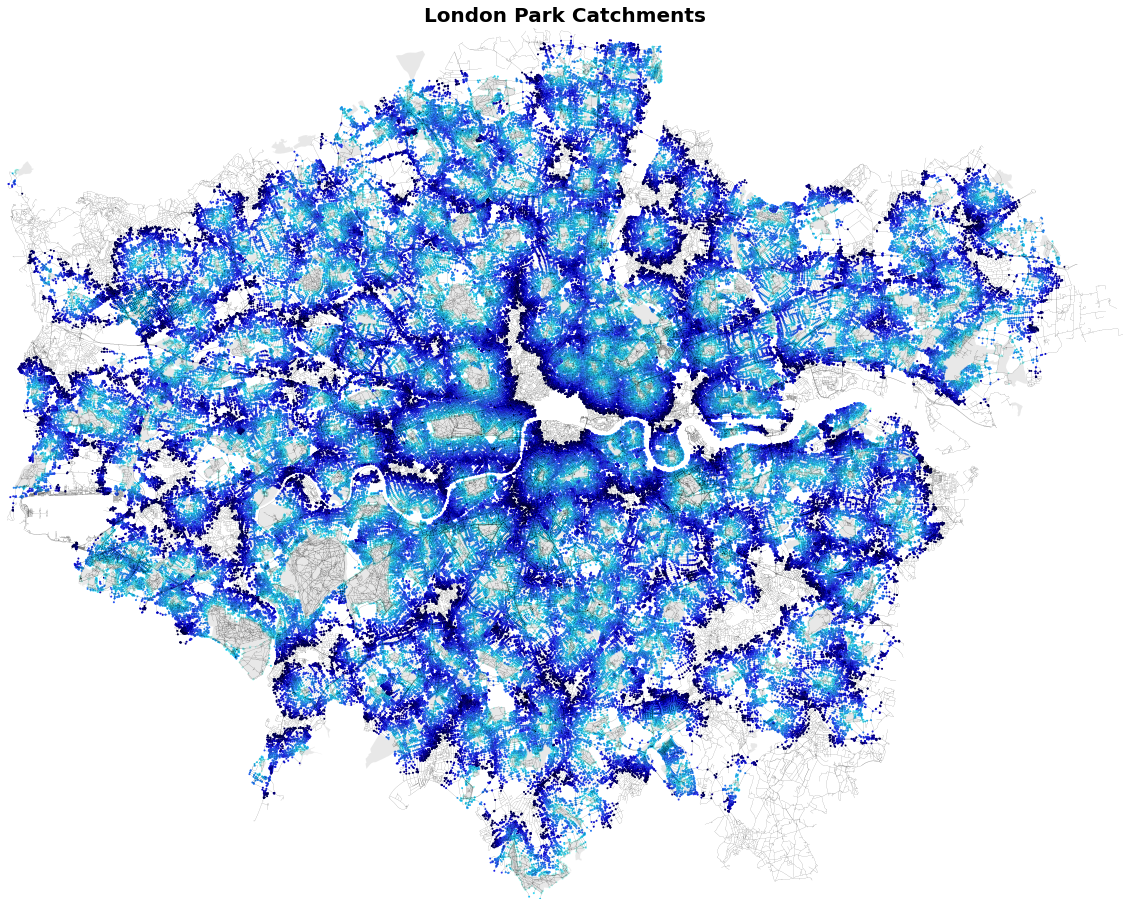

In [84]:
# same again
ax = E.plot(color='black', linewidth=0.05, figsize=(20, 20))
gpd.GeoDataFrame(cells, 
                 geometry=gpd.points_from_xy(cells.x, cells.y), 
                 crs=4326).merge(times, 
                                 left_on='child', 
                                 right_on='osmid',
                                 how='left').to_crs(27700).plot('distance', markersize=1, cmap=col, ax=ax)

parks.plot(color='lightgrey', alpha=0.5, ax=ax)

# clean up the axes
ax.set_xlim((N.geometry.x.min(), N.geometry.x.max()))
ax.set_ylim((N.geometry.y.min(), N.geometry.y.max()))
ax.set_axis_off()

# add a title
ax.set_title('London Park Catchments', fontsize=20, fontweight='bold', color='k')

# save the figure
plt.savefig('./images/accessibility/london_catchment.png', dpi=300, facecolor='w', bbox_inches='tight')

In [85]:
import imageio, os
# get the file paths of the images
imgs = os.listdir("./images/accessibility/")
# sort the images so the order is correct
imgs.sort()
# load the images
imgs = [imageio.imread(f"./images/accessibility/{x}") for x in imgs] 
# save the gif
imageio.mimsave("./images/accessibility.gif", imgs, fps=0.5);